# Notebook 18:  Ising Configurations using Deep Boltzmann Machines

## Learning Goal
The goal of this notebook is to teach readers how to generate examples using Deep Boltzmann Machines in the Paysage package. The reader should understand why generating new examples is much tougher than classifying, as well as become more acquainted with pre-training using DBMs.

## Overview

The purpose of this notebook is to show how one can employ Generative Models to learn a variational approximation to the probability distribution used to draw thermal spin configurations in the 2D Ising model.

The Hamiltonian for the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a $40\times 40$ 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.

In previous notebooks, we used our knowledge of the critical point at $T_c/J\approx 2.26$ to label the spin configurations and study the problem of classifying the states according to their phase of matter. However, in more complicated models, where the precise position of $T_c$ is not known, one cannot label the states with such an accuracy, if at all. 

As we explained in Secs. XV and XVI of the review, generative models can be used to learn a variational approximation for the probability distribution that generated the data points. By using only the 2D spin configurations, we now want to train a deep Bernoulli Boltzmann machine, the fantasy particles of which are thermal Ising configurations. 

Unlike in previous studies of the Ising dataset, here we perform the analysis at a fixed temperature $T$. We can then apply our model at three different values $T=1.75,2.25,2.75$ in the ordered, critical and disordered regions, respectively.

## Setting up Paysage

In this notebook, we use an open-source `python` package for energy-based models, called [paysage](https://github.com/drckf/paysage). Paysage requires `python>3.5`; we recommend using the package with an [Anaconda](https://www.continuum.io/downloads) environment.

To install paysage: 

* clone or download the [github repo](https://github.com/drckf/paysage)
* activate an Anaconda3 environment
* navigate to the directory which contains the paysage files
* and execute
```
pip install .
```

Documentation for paysage is available under [https://github.com/drckf/paysage/tree/master/docs](https://github.com/drckf/paysage/tree/master/docs).

### Paysage on GPUs

By default, computations in paysage are performed using `numpy`/`numexpr`/`numba` on the CPU. Since the coputation below on the Ising dataset is more intensive compared to MNIST, we want to make use of a GPU speedup.

Not all laptops have GPUs available for computation, but large computing facilities, such as supercomputing clusters, do. If you do not have access to a GPU, you can still run the code below with parameters corresponding to those used to generate the figures in Sec. XVI F, but prepare for larger waiting times if you want to reproduce the figures from the review. As discussed in the main text, energy-based models rely on Monte-Carlo inspired methods rather than backpropagation. For this reason, they tend to be more computationally expensive than generative models.

To make use of GPU power, you need to install [PyTorch](https://pytorch.org), and switch to the `pytorch` backend by changing the setting in `paysage/backends/config.json` to `pytorch`. 

Let us set up the required packages for this notebook by importing the relevant paysage modules.

## Loading the Required Packages

In [1]:
import os
import pickle
import numpy as np

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.cm as cm
import seaborn as sns
import ml_style as style
import matplotlib as mpl

mpl.rcParams.update(style.style)

# for Boltzmann machines
from paysage import backends
from paysage.models.model import Model # model constructor
from paysage import optimizers # optimizer
from paysage.layers import BernoulliLayer, GaussianLayer # layers
from paysage.batch import DataShuffler, InMemoryBatch # data handler
from paysage.fit import ProgressMonitor, SequentialMC, SGD, LayerwisePretrain, pcd
from paysage.schedules import PowerLawDecay # hyperparameter schedule
from paysage.models.model_utils import State
from paysage.penalties import l1_penalty # regularization

# fix random seed to ensure deterministic behavior
backends.set_seed(137)

## Loading the Data

To load the Ising data set, we use two functions: `unpack_data()` loads the Ising configurations from a pickled file, and casts them in a suitable shape. 

The function `Load_Ising_Dataset()` loads the data for three fixed temperatures (see names of files to be loaded below) out of the temperature set `T`, corresponding to the ordered, critical and disordered phases. These three datasets are then shuffled and returned in the form of a dictionary.

In [2]:
def unpack_data(path_to_data, data_name):
    """
    Get the data from a pickled file.

    Args:
        path_to_data (str)
        data_name (str)

    Returns:
        numpy.ndarray

    """
    # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
    # pickle reads the file and returns the Python object (1D array, compressed bits)
    with open(os.path.join(path_to_data, data_name), 'rb') as infile:
        data = pickle.load(infile)
    # Decompress array and reshape for convenience
    data = np.unpackbits(data).reshape(-1, 1600).astype('int')
    return data


def Load_Ising_Dataset():
    """
    Loads the Ising dataset.

    Args:
        None

    Returns:
        dict[numpy.ndarray]

    """
    L=40 # linear system size
    T=np.linspace(0.25,4.0,16) # temperatures
    T_c=2.26 # critical temperature in the TD limit

    # path to data directory
    #path_to_data = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'isingMC')
    path_to_data=os.path.expanduser('~')+'/Dropbox/MachineLearningReview/Datasets/isingMC/'

    # ordered states
    data_name_ordered = "Ising2DFM_reSample_L40_T=1.75.pkl"
    X_ordered = unpack_data(path_to_data,data_name_ordered)
    # critical states
    data_name_critical = "Ising2DFM_reSample_L40_T=2.25.pkl"
    X_critical = unpack_data(path_to_data,data_name_critical)
    # disordered states
    data_name_disordered = "Ising2DFM_reSample_L40_T=2.75.pkl"
    X_disordered = unpack_data(path_to_data,data_name_disordered)

    # shuffle data
    np.random.shuffle(X_ordered)
    np.random.shuffle(X_critical)
    np.random.shuffle(X_disordered)

    return {'ordered': X_ordered, 'critical': X_critical, 'disordered': X_disordered}

## Define Auxiliary Functions

To help set up the numerical experiment, we make use of the functions we defined in the notebook __NB_CXVI_RBM_mnist__. Since their functionality is explained in detail there and in Sec. XVI E of the review, we simply state the code here.

In [3]:
def ADAM_optimizer(initial, coefficient):
    """
    Convenience function to set up an ADAM optimizer.

    Args:
        initial (float): learning rate to start with
        coefficient (float): coefficient that determines the rate of
            learning rate decay (larger -> faster decay)

    Returns:
        ADAM

    """
    # define learning rate attenuation schedule
    learning_rate = PowerLawDecay(initial=initial, coefficient=coefficient)
    return optimizers.ADAM(stepsize=learning_rate)


def train_model(model, data, num_epochs, monte_carlo_steps, performance):
    """
    Train a model.

    Args:
        model (BoltzmannMachine)
        data (Batch)
        num_epochs (int)
        monte_carlo_steps (int)
        performance (ProgressMonitor)

    Returns:
        None

    """
    is_deep = model.num_layers > 2
    # make a simple guess for the initial parameters of the model
    model.initialize(data,method='glorot_normal')
    # set optimizer
    opt = ADAM_optimizer(initial,coefficient)
    # set up a Monte Carlo sampler
    sampler = SequentialMC.from_batch(model, data)
    if is_deep:
        print("layerwise pretraining")
        pretrainer = LayerwisePretrain(model, data, opt, num_epochs,
                                       method=pcd, mcsteps=monte_carlo_steps,
                                       metrics=['ReconstructionError'])
        pretrainer.train()
        # reset the optimizer using a lower learning rate
        opt = ADAM_optimizer(initial/10.0, coefficient)
    print("use persistent contrastive divergence to fit the model")
    trainer=SGD(model, data, opt, num_epochs, sampler,
                method=pcd, mcsteps=monte_carlo_steps, monitor=performance)
    trainer.train()


def compute_reconstructions(model, data):
    """
    Computes reconstructions of the input data.
    Input v -> h -> v' (one pass up one pass down)

    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)

    Returns:
        tensor of shape (num_samples, num_visible_units)

    """
    # a configuration sampled from an RBM needs to specify the values
    # of both the visible and hidden units
    # since the data only specify the visible units, we need to initialize
    # some hidden unit values
    # the visible and hidden units are stored in a State object
    data_state = State.from_visible(data, model)
    # define MC sampler
    sampler = SequentialMC(model)
    # define a starting point for MC sampler
    sampler.set_state(data_state)
    # compute reconstructions
    recons = model.deterministic_iteration(1, sampler.state).units[0]
    return backends.to_numpy_array(recons)


def compute_fantasy_particles(model,data,num_steps,mean_field=True):
    """
    Draws samples from the model using Gibbs sampling Markov Chain Monte Carlo .
    Starts from randomly initialized points.

    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)
        num_steps (int): the number of update steps
        mean_field (bool; optional): run a final mean field step to compute probabilities

    Returns:
        tensor of shape (num_samples, num_visible_units)

    """
    # compute random data sample
    random_sample = model.random(data)
    # get model state from visible layer
    model_state = State.from_visible(random_sample,model)
    # define MC sampler
    sampler = SequentialMC(model)
    # change sampler state
    sampler.set_state(model_state)
    # does n_steps forward and backward passes
    sampler.update_state(num_steps)
    if mean_field: # see Hinton's 2012 paper: trick (practical guide for training)
        fantasy_particles = model.mean_field_iteration(1, sampler.state).units[0]
    else:
        fantasy_particles = sampler.state.units[0]
    return backends.to_numpy_array(fantasy_particles)


def plot_image_grid(image_array, shape, vmin=0, vmax=1, cmap=cm.gray_r,
                    row_titles=None, filename=None):
    """
    Plot a grid of images.

    Args:
        image_array (numpy.ndarray)
        shape (tuple)
        vmin (optional; float)
        vmax (optional; float)
        cmap (optional; colormap)
        row_titles (optional; List[str])
        filename (optional; str)

    Returns:
        None

    """
    array = backends.to_numpy_array(image_array)
    nrows, ncols = array.shape[:-1]
    f = plt.figure(figsize=(2*ncols, 2*nrows))
    grid = gs.GridSpec(nrows, ncols)
    axes = [[plt.subplot(grid[i,j]) for j in range(ncols)] for i in range(nrows)]
    for i in range(nrows):
        for j in range(ncols):
            sns.heatmap(np.reshape(array[i][j], shape),
                ax=axes[i][j], cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)
            axes[i][j].set(yticks=[])
            axes[i][j].set(xticks=[])

    if row_titles is not None:
        for i in range(nrows):
            axes[i][0].set_ylabel(row_titles[i], fontsize=36)

    plt.tight_layout()
    plt.show(f)
    if filename is not None:
        f.savefig(filename)
    plt.close(f)

## Building and Training the Deep Boltzmann Machine for the Ising model

To study this problem, we construct a deep Boltzmann machine with two hidden layers of $80$ and $8$ units each. We apply L1 normalization to all weights of the model. We mention that the figures in the review were produced for a DBM with more hidden units.

To train our DBM, we use ADAM-based Persistent Contrastive Divergence.

More detailed explanations about how to use Paysage to construct (deep) generative models, can be found in notebook __NB_CXVI_RBM_mnist__, and Sec. XVI E of the review.

training in the ordered phase
layerwise pretraining
training model 0

End of epoch 0: 
-ReconstructionError: 27.768264
Epoch took 7.51 seconds

End of epoch 1: 
-ReconstructionError: 27.802482
Epoch took 7.05 seconds

End of epoch 2: 
-ReconstructionError: 27.806807
Epoch took 6.56 seconds

End of epoch 3: 
-ReconstructionError: 27.796762
Epoch took 6.69 seconds

End of epoch 4: 
-ReconstructionError: 27.774935
Epoch took 6.85 seconds

End of epoch 5: 
-ReconstructionError: 27.761763
Epoch took 6.23 seconds

End of epoch 6: 
-ReconstructionError: 27.776438
Epoch took 6.67 seconds

End of epoch 7: 
-ReconstructionError: 27.753297
Epoch took 6.60 seconds

End of epoch 8: 
-ReconstructionError: 27.741440
Epoch took 6.74 seconds

End of epoch 9: 
-ReconstructionError: 27.734140
Epoch took 6.57 seconds

training model 1

End of epoch 0: 
-ReconstructionError: 5.664001
Epoch took 1.35 seconds

End of epoch 1: 
-ReconstructionError: 5.260504
Epoch took 1.37 seconds

End of epoch 2: 
-Reconstr

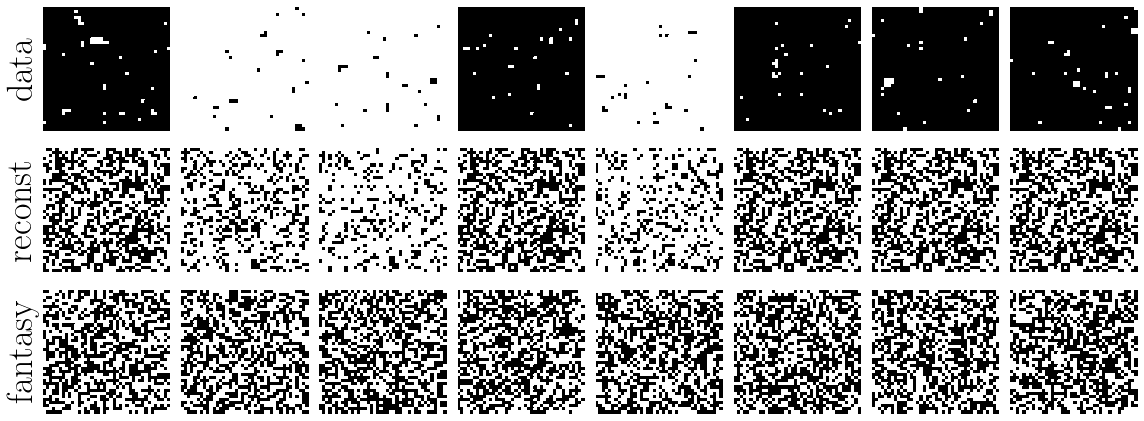

training in the critical phase
layerwise pretraining
training model 0

End of epoch 0: 
-ReconstructionError: 28.121353
Epoch took 7.24 seconds

End of epoch 1: 
-ReconstructionError: 28.080011
Epoch took 6.90 seconds

End of epoch 2: 
-ReconstructionError: 28.042388
Epoch took 6.26 seconds

End of epoch 3: 
-ReconstructionError: 27.996535
Epoch took 6.22 seconds

End of epoch 4: 
-ReconstructionError: 27.924720
Epoch took 7.16 seconds

End of epoch 5: 
-ReconstructionError: 27.877778
Epoch took 6.23 seconds

End of epoch 6: 
-ReconstructionError: 27.814034
Epoch took 6.45 seconds

End of epoch 7: 
-ReconstructionError: 27.764726
Epoch took 6.16 seconds

End of epoch 8: 
-ReconstructionError: 27.741476
Epoch took 6.73 seconds

End of epoch 9: 
-ReconstructionError: 27.690892
Epoch took 7.54 seconds

training model 1

End of epoch 0: 
-ReconstructionError: 6.007452
Epoch took 1.68 seconds

End of epoch 1: 
-ReconstructionError: 5.771695
Epoch took 1.62 seconds

End of epoch 2: 
-Reconst

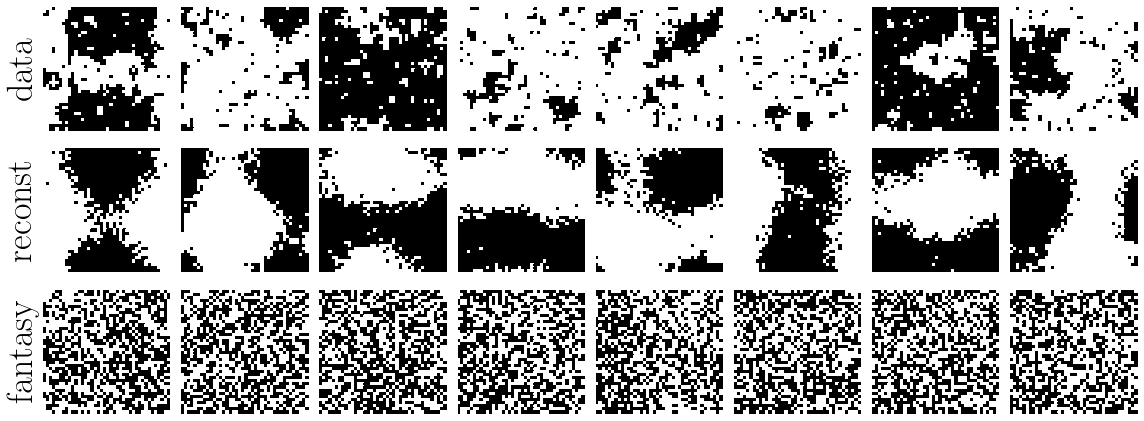

training in the disordered phase
layerwise pretraining
training model 0

End of epoch 0: 
-ReconstructionError: 28.240583
Epoch took 7.23 seconds

End of epoch 1: 
-ReconstructionError: 28.186628
Epoch took 7.98 seconds

End of epoch 2: 
-ReconstructionError: 28.085735
Epoch took 7.48 seconds

End of epoch 3: 
-ReconstructionError: 27.968455
Epoch took 7.14 seconds

End of epoch 4: 
-ReconstructionError: 27.874558
Epoch took 6.67 seconds

End of epoch 5: 
-ReconstructionError: 27.788685
Epoch took 7.63 seconds

End of epoch 6: 
-ReconstructionError: 27.700018
Epoch took 7.03 seconds

End of epoch 7: 
-ReconstructionError: 27.623269
Epoch took 8.13 seconds

End of epoch 8: 
-ReconstructionError: 27.586790
Epoch took 7.73 seconds

End of epoch 9: 
-ReconstructionError: 27.533707
Epoch took 6.61 seconds

training model 1

End of epoch 0: 
-ReconstructionError: 5.808580
Epoch took 1.57 seconds

End of epoch 1: 
-ReconstructionError: 5.811063
Epoch took 1.53 seconds

End of epoch 2: 
-Recon

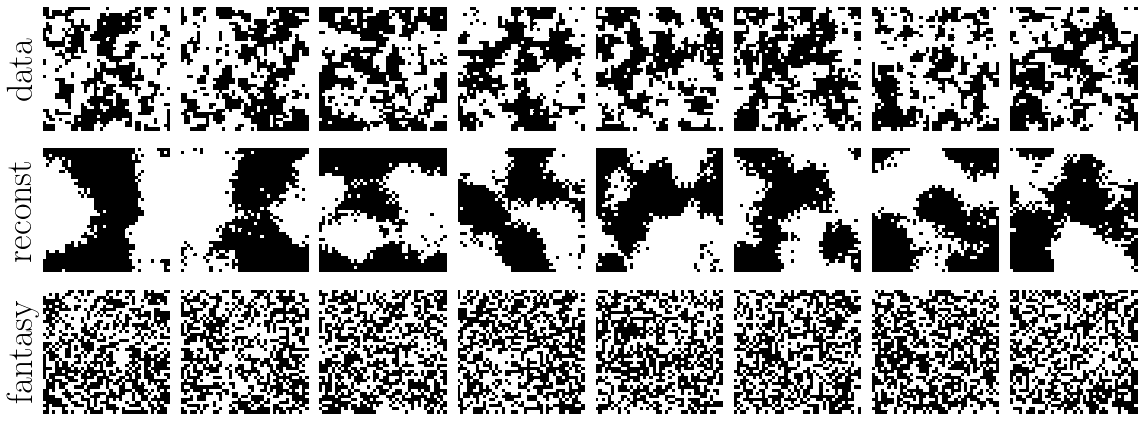

In [4]:
image_shape = (40,40) # 40x40=1600 spins in every configuration
num_to_plot = 8 # of data points to plot

# parameters the user needs to choose
batch_size = 100 # batch size
num_epochs = 10 # training epochs
monte_carlo_steps = 2 # number of MC sampling steps
initial = 1E-3 # initial learning rate
coefficient = 1.0 # controls learning rate decay
num_fantasy_steps = 100 # MC steps when drawing fantasy particles
lmbda = 1E-6 # stength of the L1 penalty
num_hidden_units = [80, 8] # hidden layer units

# load data
data =  Load_Ising_Dataset()

# preallocate data dicts
dbm_L1_reconstructions = {}
dbm_L1_fantasy = {}
true_examples = {}
dbm_models = {}

for phase in ['ordered','critical','disordered']:
    print('training in the {} phase'.format(phase))

    # set up an object to read minibatch of the data
    batch_reader = InMemoryBatch(data[phase], batch_size, train_fraction=0.8)
    batch_reader.reset_generator(mode='train')

    # the reconstruction error will be computed from the validation set
    performance = ProgressMonitor(batch_reader, metrics=['ReconstructionError'])

    ##### Bernoulli RBM
    dbm_L1 = Model(
            [BernoulliLayer(batch_reader.ncols)] + \
            [BernoulliLayer(n) for n in num_hidden_units]
            )

    # add an L1 penalty to the weights
    for j_, weight in enumerate(dbm_L1.weights):
        weight.add_penalty({'matrix': l1_penalty(lmbda)})

    # train the model
    train_model(dbm_L1, batch_reader, num_epochs, monte_carlo_steps, performance)

    # store model
    dbm_models[phase]=dbm_L1

    # reset the generator to the beginning of the validation set
    batch_reader.reset_generator(mode='validate')
    examples = batch_reader.get(mode='validate') # shape (batch_size, 1600)
    true_examples[phase] = examples[:num_to_plot]

    # compute reconstructions
    reconstructions = compute_reconstructions(dbm_L1, true_examples[phase])
    dbm_L1_reconstructions[phase] = reconstructions

    # compute fantasy particles
    fantasy_particles = compute_fantasy_particles(dbm_L1,
                                                  true_examples[phase],
                                                  num_fantasy_steps,
                                                  mean_field=False)
    dbm_L1_fantasy[phase] = fantasy_particles

    # plot results and save fig
    reconstruction_plot = plot_image_grid(
            np.array([
                    true_examples[phase],
                    dbm_L1_reconstructions[phase],
                    dbm_L1_fantasy[phase]
                    ]),
            image_shape, vmin=0, vmax=1,
            row_titles=["data", "reconst", "fantasy"],
            filename='DBM_Ising-'+phase+'.png')

# save data
save_file_name='./DBM_ising_training_data-L=40.pkl'
pickle.dump([dbm_models, true_examples, dbm_L1_fantasy, dbm_L1_reconstructions,
            image_shape, num_to_plot, batch_size, num_epochs, monte_carlo_steps,
            initial, coefficient, num_fantasy_steps, lmbda,num_hidden_units,
            ], open(save_file_name, "wb" ) )

## Exercises

* Pick different temperatures $T$ from the available set and repeat the learning procedure. Can you find more suitable hyperparameters (such as the number of hidden units, the learning rate, the regularization strength, and the SGD optimizer parameters) that give better results?
* Generate a large enough set of fantasy particles and compute their magnetization, energy (and other thermodynamic quantities). Comparing these values to the original MC samples provides a useful measure for the performance of the DBM.  
* If you have read the review, by now you are an ML expert: you can play the following game: use the RBM to generate a large sample of Ising states, and then apply your pre-trained DNN or CNN classifier from Secs IX and XI to label them. 